In [ ]:
# Please don't change this cell.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Variational Autoencoder
In this homework, we will try to implement **variational autoencoder**. Given a dataset, variational autoencoder tries to learn the distribution of the dataset itself. We will again test our model on peripheral blood mononuclear cells(PBMCs) single-cell gene expression dataset.

**You may find those material useful for your implementation**: 

* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
* [Implementing VAE using Pytorch](http://www.garethausten.com/blog/variational-autoencoders)

## Read in the data
First, let's read in the PBMCs data that we will use for the training. 

If you're using `colab` please make sure to upload your file(include `celltypes_PBMC.txt` and `counts_PBMC.csv`) first.


In [ ]:
# Please don't change this cell.

expr_ctrl = pd.read_csv("counts_PBMC.csv", sep = ",", index_col = 0).values
anno_ctrl = pd.read_csv("celltypes_PBMC.txt", sep = "\t", header = None)
expr_ctrl = StandardScaler().fit_transform(expr_ctrl)

# Here we first reduce the dimension with PCA to speed up the training process
expr_ctrl = PCA(n_components = 100).fit_transform(expr_ctrl)
expr_ctrl = torch.FloatTensor(expr_ctrl)

Variational autoencoder assumes that for each high-dimensional data $X$, there exist low dimensional latent variable $Z$ that help generate data similar to $X$. The distribution $P(Z|X,\theta)$ can be estimated using encoder structure. The posterior distribution $P(Z|X,\theta)$ is assumed to be Gaussian:

\begin{equation}
P(Z|X,\theta) = \mathcal{N}(f_\mu(X,\theta_1), f_\sigma(X,\theta_2)\mathbf{I})
\end{equation}
where $f_\mu(z,\theta_1)$ and $f_\sigma(z,\theta_2)$ are modeled with neural network.


## Encoder
Now let's implement the encoder part. Here we use two three-layer fully connected neural networks to model $f_\mu(X,\theta_1)$ and $f_\sigma(X,\theta_2)$. We assume the first two layers of $f_\mu(X,\theta_1)$ and $f_\sigma(X,\theta_2)$ are shared(`self.lin1`, `self.lin2`), and the last layer is different for those two functions (`self.fc_mu` for $f_\mu(X,\theta_1)$ and `self.fc_logvar` for $f_\sigma(X,\theta_2)$). Assume the dimension of $\mu_Z$ and $\sigma_Z$(output of the encoder) are $2$. You can use `ReLU` as the activation function between layers. Feel free to try different dimensions for the other layers. 

In [ ]:
class encoder(nn.Module):
  def __init__(self, in_features, out_features):
    super(encoder, self).__init__()
    # =========================================
    # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
    # We'd recommend you to use nn.Linear() function in pytorch.
    # =======================================
    self.lin1 = nn.Linear(in_features,25)
    self.lin2 = nn.Linear(25,10)
    self.fc_mu = nn.Linear(10,out_features)
    self.fc_logvar = nn.Linear(10,out_features)

  def forward(self, x):
    # =========================================
    # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
    # We'd recommend you to use F.relu() for the activation function.
    # There should be no activation function for the output. 
    # =========================================
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)

    return x_mu, x_logvar

## Decoder
The decoder models $P(X|Z)$. We assume that $P(X|Z) = \mathcal{N}(f_{de}(z), \sigma \mathbf{I})$, and the decoder models $f_{de}(z)$ three fully connected layers, `self.lin1`, `self.lin2`, `self.lin3`. Feel free to try different dimensions for the layers, but please make sure the input dimension equals to the dimension of $Z$ and the output dimension equals to the dimension of $X$.

In [ ]:
class decoder(nn.Module):
  def __init__(self, in_features, out_features):
    super(decoder, self).__init__()
    # =========================================
    # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
    # =========================================
    self.lin1 = nn.Linear(out_features,10)
    self.lin2 = nn.Linear(10,25)
    self.lin3 = nn.Linear(25,in_features)

  def forward(self, x):
    # =========================================
    # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
    # We'd recommend you to use F.relu() for the activation function.
    # There should be no activation function for the output.     
    # =========================================
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = self.lin3(x)
    return x

## VAE
After implementing the encoder and decoder, let's assemble them into VAE. 

VAE estimates the parameters within the encoder and decoder by maximizing the expectation of log likelihood function:
\begin{equation}
\begin{aligned}
\hat{\theta} &= \arg\max_{\theta} \int P(Z,\theta)\log P(X|Z, \theta)dZ\\
&= \arg\max_{\theta} \mathbb{E}_{Z\sim P(Z,\theta)}[\log P(X|Z, \theta)]
\end{aligned}
\end{equation}
Instead of integrating over $P(Z,\theta)$(which is computationally expensive), we uses $P(Z|X,\theta)$ (**modeled by the encoder**) and **sample one point $\hat{Z}$ from $P(Z|X,\theta)$**, and the formula reduce to
\begin{equation}
\begin{aligned}
\hat{\theta} &= \arg\max_{\theta}  \log P(X|\hat{Z}, \theta),\quad\hat{Z}\sim P(Z|X,\theta)
\end{aligned}
\end{equation}
Assuming the distribution $P(X|\hat{Z}, \theta)$ to be Gaussian, optimizing above loss function can be reduced to minimizing mean square error between input $X$ and reconstructed $\hat{X}$.

You will need to:

* **Initialize the VAE model**: Complete `__init__` function, declare encoder and decoder using the classes we defined above.
* **Sampling process**: Complete `latent_sample` function, sample `z` from the output of encoder. VAE uses reparameterization trick for the sampling process.
* **Loss function**: There are two parts in the loss function: one is the mse loss between input data and output result, the other is the kl divergence between $P(Z|X, \theta)$ and $\mathcal{N}(\mathbf{0}, \mathbf{I})$.
* **forward pass**: the `forward` function in `variational_autoencoder`.


In [ ]:
class variational_autoencoder(nn.Module): 
  def __init__(self, in_features, latent_dims = 2):
    super(variational_autoencoder,self).__init__()
    # =========================================
    # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
    # =========================================
    # encoder
    self.enc = encoder(in_features,latent_dims)
    # decoder
    self.dec = decoder(in_features,latent_dims)

  def forward(self,x):
    # =========================================
    # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
    # =========================================
    # encoder
    x_mu, x_logvar = self.enc.forward(x)
    # latent z sampling
    latent_z = self.latent_sample(x_mu,x_logvar)
    # decoder
    x = self.dec.forward(latent_z)
    return x, x_mu, x_logvar
  
  def latent_sample(self, mu, logvar):
    # =========================================
    # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
    # =========================================
    # reparameterization, z = mu + std * N(0,I) 
    if self.training:
      # z ~ N(mu, std^2I), note that std should be positive, 
      # logvar can be negative as the output of linear layer, you may consider using exponential function
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      z = mu + eps*std
      return z
    # evaluation 
    else:
      return mu
  
def MSE_KL(input, target, mu, logvar, beta):
  # =========================================
  # COMPLETE THE METHOD; YOU CAN ADD MORE LINES IF YOU WANT
  # =========================================
  # mse is the mean square error between input and output
  loss = nn.MSELoss()
  mse = loss(input,target)
  # ks is kl-divergence loss
  kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  # beta is the regularization value
  return mse + beta * kl

In [ ]:
# Please don't change this cell.

def train_model(model, optimizer, n_epochs=10, beta = 0.001):

    batch_size=100
    losses = []

    # we'll train the network for 10 epochs
    step = 0
    for epoch in range(n_epochs):
        # randomize the order of the data each time through
        random_order = np.random.permutation(expr_ctrl.shape[0])
        data_randomized = expr_ctrl[random_order]

        # train the network on batches of size `batch_size`
        for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
            step += 1

            # update the network weights to minimize the loss
            output, x_mu, x_logvar = model(data_batch)

            # get loss
            loss = MSE_KL(input = data_batch, target = output, mu = x_mu, logvar = x_logvar, beta = beta)

            # print the loss every 100 epochs
            if step % 100 == 0:
                print("Step: {} Loss: {:.3f}".format(step, loss.item()))

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()
            losses.append(loss)

    return losses

In [ ]:
ae = variational_autoencoder(in_features = expr_ctrl.shape[1])
# training mode
ae.train()

# Learning rate for the optimizer is a key hyperparameter to play around with when we need to train the model.
# Please try with different learning rate and beta(weight of kl divergence loss), find the one that is suitable for our task.
learning_rate = 0.04
beta = 0.0001

optimizer = optim.SGD(ae.parameters(), lr=learning_rate)

losses = train_model(ae, optimizer = optimizer, n_epochs = 100, beta = beta)

Step: 100 Loss: 4.644
Step: 200 Loss: 4.914
Step: 300 Loss: 4.993
Step: 400 Loss: 5.313
Step: 500 Loss: 6.137
Step: 600 Loss: 5.072
Step: 700 Loss: 4.260
Step: 800 Loss: 4.542
Step: 900 Loss: 5.959
Step: 1000 Loss: 4.926
Step: 1100 Loss: 4.629
Step: 1200 Loss: 3.849
Step: 1300 Loss: 5.560
Step: 1400 Loss: 4.596
Step: 1500 Loss: 5.182
Step: 1600 Loss: 4.677
Step: 1700 Loss: 3.585
Step: 1800 Loss: 4.847
Step: 1900 Loss: 6.235
Step: 2000 Loss: 3.793
Step: 2100 Loss: 5.512
Step: 2200 Loss: 5.230
Step: 2300 Loss: 3.842
Step: 2400 Loss: 4.522
Step: 2500 Loss: 4.418
Step: 2600 Loss: 4.276
Step: 2700 Loss: 4.987
Step: 2800 Loss: 4.192
Step: 2900 Loss: 5.217
Step: 3000 Loss: 3.985


In [ ]:
# Please don't change this cell.

def plot_latent(z, anno, save = None, figsize = (10,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    cluster_types = set([x for x in np.unique(anno)])
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]
        ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    
    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)





## Visualization
After training the model, let's visualize the latent space generated by variational autoencoder. Please discuss with your group memeber about the result and answer following two questions in your paper solution: 

* How the visualization is different from the latent space generated by the autoencoder we implemented in the last homework? 
* What is the difference between variational autoencoder and autoencoder?  

VAE.pdf


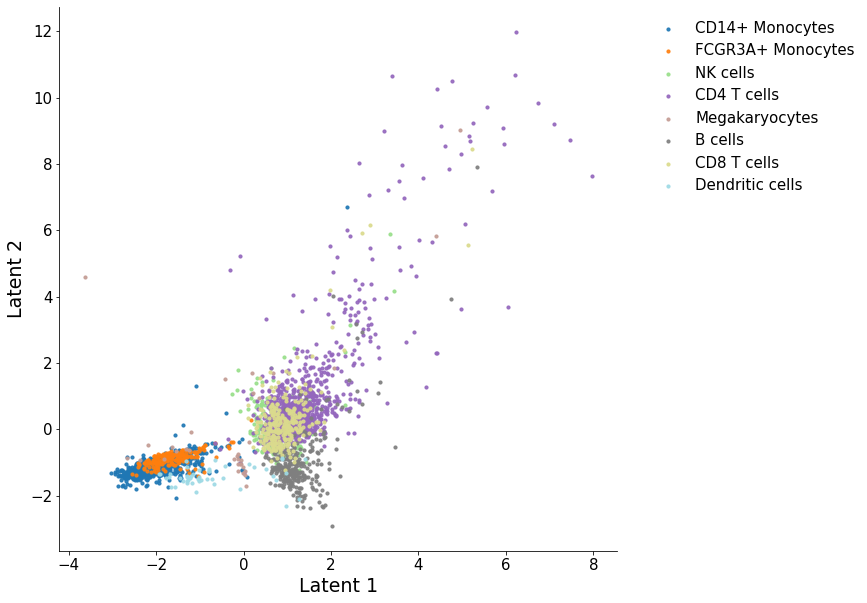

In [ ]:
# Please don't change this cell.

ae.eval()
with torch.no_grad():
    ae_coordinates = ae(expr_ctrl)
    ae_coordinates = ae_coordinates[1]

plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "VAE.pdf")